# Machine Learning in Python - Project 2

Due Friday, Apr 11th by 4 pm.

*Include contributors names in notebook metadata or here*

## Setup


In [54]:
# Data libraries
import pandas as pd
import numpy as np
# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
# Plotting defaults
plt.rcParams['figure.figsize'] = (8,5)
plt.rcParams['figure.dpi'] = 80
# sklearn modules
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (
    classification_report, accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay
)
# Imbalanced-learn modules
from imblearn.pipeline import Pipeline as ImPipeline
from imblearn.over_sampling import SMOTE
# XGBoost
from xgboost import XGBClassifier
# SHAP
import shap
# Skewness
from scipy.stats import skew, probplot
# Statsmodels for VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [41]:
# Load data in freddiemac.csv with specific dtype handling for categorical and coded columns
d = pd.read_csv("freddiemac.csv", dtype={
    'cd_msa': str, 'cnt_units': str, 'cnt_borr': str, 'zipcode': str, 'id_loan_rr': str, 'rr_ind':str, 'property_val': str
})

# Introduction

Mortgage default prediction plays a critical role in credit risk assessment and portfolio management, particularly for large institutions such as Freddie Mac. Early identification of high-risk loans allows lenders to take proactive measures, reduce potential losses, and comply with regulatory requirements. This project develops a machine learning model to predict the likelihood of loan default using historical data from Freddie Mac’s Single-Family Loan-Level Dataset (2017–2020).

The dataset includes over 120,000 completed loans, with features covering borrower demographics, credit indicators (e.g., FICO score, DTI, LTV), loan structure, property characteristics, and loan outcomes (prepaid or defaulted). To prepare the data for modeling, we conduct preprocessing steps including missing value imputation, categorical encoding, numerical transformation to correct skewness, and interaction feature engineering to capture combined risk signals.

We begin with exploratory data analysis (EDA) to understand the distribution of key variables and the relationships between borrower characteristics and default risk. Logistic regression is used as a baseline model, followed by XGBoost as the final model due to its strong performance with imbalanced, tabular data. Hyperparameter tuning is performed using randomized search with cross-validation, and model explainability is addressed using SHAP values.

Results show that FICO score is the most influential predictor, while other important features include DTI, borrower count, and interaction terms such as LTV × DTI. The final XGBoost model achieved a recall of 69.8%, ROC-AUC of 0.7656, and significantly improved performance over the baseline. These findings demonstrate that machine learning, when properly calibrated and interpreted, can provide an effective and transparent tool for identifying loans at risk of default and informing risk management decisions.

# Exploratory Data Analysis and Feature Engineering



This section explores the structure and quality of the dataset to prepare it for predictive modeling. We begin by filtering and inspecting the target variable, handling missing data, and removing irrelevant or redundant columns.

The dataset is then split into training and testing sets to avoid data leakage. Exploratory analysis is performed on numerical and categorical variables to identify trends and potential predictors of loan default. Finally, we apply appropriate transformations and create new features to improve model performance.

## Filter Active Loans and Check Target Distribution


To ensure our modeling task only focuses on completed loan outcomes, we first filter out active loans. We then examine the distribution of the target variable (loan_status) to understand class imbalance and motivate later adjustments in modeling strategy.

In [42]:
# Filter out active loans (only keep 'default' and 'prepaid')
d_filtered = d[d['loan_status'].isin(['default', 'prepaid'])].copy()
d_filtered['loan_status'] = d_filtered['loan_status'].map({'default': 1, 'prepaid': 0})
print("Data shape after filtering active loans:", d_filtered.shape)

# Check target distribution
target_dist = d_filtered['loan_status'].value_counts(normalize=True) * 100
print("\nTarget Distribution (%):")
print(target_dist)

Data shape after filtering active loans: (126705, 33)

Target Distribution (%):
loan_status
0    99.411231
1     0.588769
Name: proportion, dtype: float64


We first filter out active loans and retain only those labeled as “prepaid” and “default”. These are encoded as 0 and 1 respectively for binary classification.

After filtering, we are left with 126,705 loan records. However, only 0.59% of them are defaults, confirming a highly imbalanced target distribution. This imbalance poses challenges for classification and will be explicitly addressed in later stages of the pipeline.


## Find Missing Values and Drop Features

Here, we identifiy columns with excessive missingness or low informational value.

In [43]:
# Define not available values as missing values
missing_values = {'fico': [9999], 'flag_fthb': ['9'], 'mi_pct': [999], 'cnt_units': ['99'], 'occpy_sts': ['9'], 
                  'cltv': [999], 'dti': [999], 'ltv': [999], 'channel': ['9'], 'prop_type': ['99'], 'loan_purpose': ['9'], 
                  'program_ind': ['9'], 'property_val': ['9'], 'mi_cancel_ind': ['7', '9'], 'flag_sc': ['N'], 'rr_ind': ['N']
}
# Replace missing values with NaN
for col, codes in missing_values.items():
    d_filtered[col] = d_filtered[col].replace(codes, np.nan)
    
# Check for missing values
missing_values = d_filtered.isna().sum().sort_values(ascending=False)
missing_percent = (missing_values / len(d_filtered)) * 100
missing_df = pd.DataFrame({'Missing Count': missing_values, 'Percentage (%)': missing_percent})[missing_values > 0]
print("Missing Values in Training Data:")
print(missing_df)

Missing Values in Training Data:
               Missing Count  Percentage (%)
id_loan_rr            125406       98.974784
rr_ind                125406       98.974784
flag_sc               121241       95.687621
program_ind           116496       91.942702
mi_cancel_ind          87026       68.683951
cd_msa                 11294        8.913618
dti                     1304        1.029162
property_val              94        0.074188
fico                      24        0.018942
ltv                        1        0.000789
mi_pct                     1        0.000789
cltv                       1        0.000789


Many features contain placeholder values indicating missingness (e.g., '9', '999', 'N'). These are first replaced with standard NaN. We then examine the proportion of missing data per column. Features such as id_loan_rr, rr_ind, and flag_sc have over 90% missing values, making them unsuitable for modeling.

Next step we will remove features that are mostly missing, constant across all rows, or irrelevant for prediction (e.g., IDs and redundant date fields).

In [44]:
print("Columns to drop:")
# Check for columns with >90% missing values
missing_pct = d_filtered.isna().mean()
high_missing_cols = missing_pct[missing_pct > 0.9].index.tolist()
print("Columns with >90% missing values:", high_missing_cols)

# Check for columns with all same non-NaN values
constant_cols = []
for col in d_filtered.columns:
    if d_filtered[col].nunique(dropna=True) == 1:
        constant_cols.append(col)
print("Columns with constant values:", constant_cols)

# Drop identifier columns
ide_cols = ['id_loan', 'seller_name', 'servicer_name']
print("Identifier columns:", ide_cols)

# Drop date columns redundant with 'orig_loan_term' (loan term is derived from first payment and maturity dates)
date_cols = ['dt_first_pi', 'dt_matr']
print("Date columns:", date_cols)

# Drop columns with constant values, >90% missing values, and identifier columns
cols_to_drop = list(set(constant_cols + high_missing_cols + ide_cols + date_cols))
d_filtered = d_filtered.drop(columns=cols_to_drop, errors='ignore')

Columns to drop:
Columns with >90% missing values: ['flag_sc', 'id_loan_rr', 'program_ind', 'rr_ind']
Columns with constant values: ['ppmt_pnlty', 'prod_type', 'flag_sc', 'rr_ind', 'io_ind']
Identifier columns: ['id_loan', 'seller_name', 'servicer_name']
Date columns: ['dt_first_pi', 'dt_matr']


Several features are removed to enhance model efficiency and reduce the risk of overfitting. Columns with a high missing rate (over 90%) are excluded, as they tend to introduce noise and offer limited modeling value. Features with constant values are also dropped due to their lack of variability and predictive power. In addition, identifiers such as loan IDs and seller or servicer names are not generalizable and are therefore excluded. Finally, date-related features such as dt_first_pi and dt_matr are removed because the loan term is already captured by the variable orig_loan_term, making the original dates redundant. 

## Train-Test Split

Before any detailed exploration, we split the dataset into training and testing sets. This avoids data leakage and ensures a fair evaluation of model performance on unseen data.

In [45]:
# Split data before EDA to avoid data leakage
X = d_filtered.drop('loan_status', axis=1)
y = d_filtered['loan_status']

# Stratified split to maintain class balance
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    shuffle= True,
    test_size=0.2, 
    stratify=y,  # Maintain class distribution
    random_state=42
)

We use the train_test_split function to divide the dataset into 80% training and 20% testing data. By setting stratify=y, we ensure that the distribution of the minority class is preserved in both subsets, thereby maintaining the overall imbalance in the test set.

## Missing Value Imputation

To ensure model compatibility and avoid training errors due to missing values, we applied imputation strategies tailored to the data type and distribution of each variable. 

In [46]:
# Numerical columns: Median imputation
num_cols = ['fico', 'mi_pct', 'cltv', 'dti', 'ltv']
num_imputer = SimpleImputer(strategy='median')
X_train[num_cols] = num_imputer.fit_transform(X_train[num_cols])
X_test[num_cols] = num_imputer.transform(X_test[num_cols])

# Ordinal categorical: Most frequent category
ord_cols = ['property_val']
ord_imputer = SimpleImputer(strategy='most_frequent')
X_train[ord_cols] = ord_imputer.fit_transform(X_train[ord_cols])
X_test[ord_cols] = ord_imputer.transform(X_test[ord_cols])

# Nominal categorical: Fill with 'Unknown'
cat_cols = ['cd_msa', 'mi_cancel_ind']
X_train[cat_cols] = X_train[cat_cols].fillna('Unknown')
X_test[cat_cols] = X_test[cat_cols].fillna('Unknown')

For numerical columns, we used the median rather than the mean, as the median is more robust to skewed distributions and outliers. For the ordinal categorical variable property_val, we imputed using the most frequent category to preserve its rank order while minimizing distortion from rare categories. Finally, for nominal categorical features like cd_msa and mi_cancel_ind, which do not have an inherent order, we filled missing values with the placeholder “Unknown”, maintaining their categorical structure while allowing the model to treat them as a distinct group during encoding. This structured approach ensures that we preserve key information while keeping the dataset clean and model-ready.

## Exploratory Data Analysis (EDA)

In this section, we explore patterns and relationships in the training data to better understand the factors associated with loan defaults. We begin by merging features and target labels for visualization, then examine both numerical and categorical variables, as well as potential correlations, to guide later modeling decisions.

Before performing EDA, we combined the training features and labels into a single DataFrame (train_df) for easier analysis, allowing for the inspection of feature distributions, class imbalance, and relationships between features and the target variable (loan_status).

In [47]:
# Combine training data for EDA
train_df = pd.concat([X_train, y_train], axis=1)
print("\nTraining data shape:", train_df.shape)


Training data shape: (101364, 21)


### Numerical Features Analysis

In this section, we visualize and compare the distributions of key numerical features across prepaid and defaulted loans. This helps us identify which features may be informative for classification. We also assess skewness to determine whether transformations are needed to improve model performance.

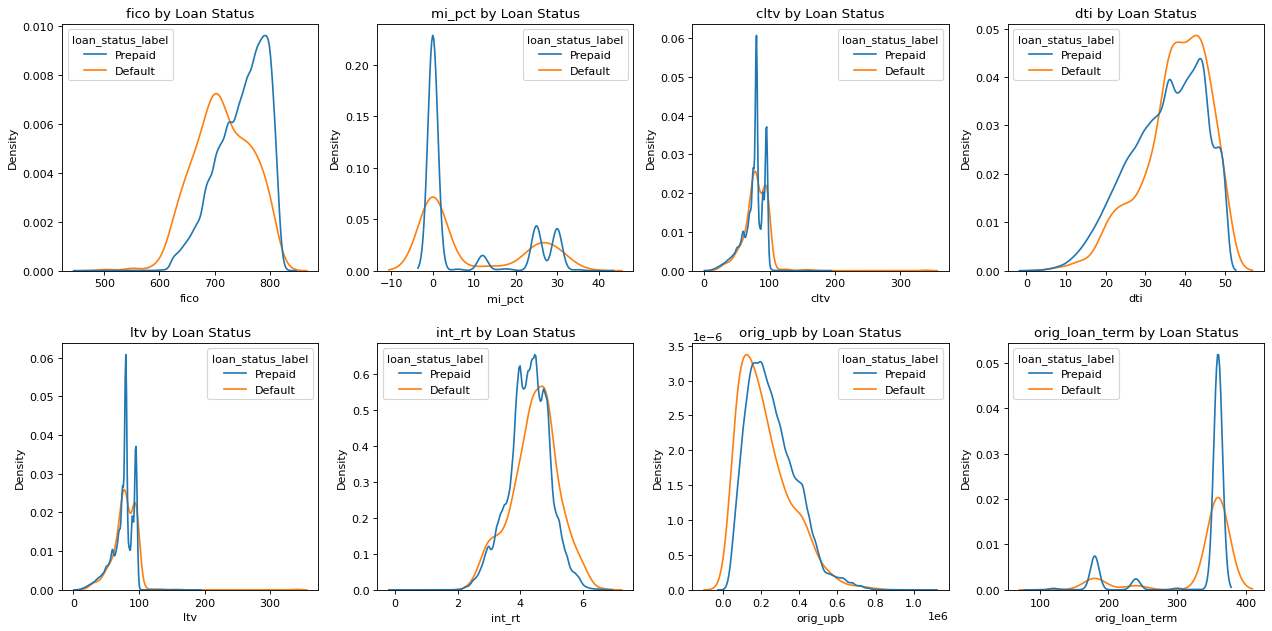

In [48]:
num_cols = ['fico', 'mi_pct', 'cltv', 'dti', 'ltv', 'int_rt', 'orig_upb', 'orig_loan_term'] # Numerical columns
n = 2 # Number of rows for subplots
m = len(num_cols) // n + len(num_cols) % n # Number of columns for subplots

# Numerical feature distribution comparison by loan status
train_df['loan_status_label'] = train_df['loan_status'].map({0: 'Prepaid', 1: 'Default'})

fig, axes = plt.subplots(n, m, figsize=(16, 8))
axes = axes.flatten()

for i, col in enumerate(num_cols):
    if col in train_df.columns:
        sns.kdeplot(data=train_df, x=col, hue='loan_status_label', ax=axes[i], common_norm=False)
        axes[i].set_title(f'{col} by Loan Status')
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('Density')

plt.tight_layout()
plt.show()


This figure illustrates the distribution of key numerical features for loans that were prepaid versus those that defaulted. Several features display meaningful differences between the two groups. For instance, FICO scores around 700 are more associated with defaults, while scores closer to 800 are more common among prepaid loans, suggesting that credit score is a strong predictor of loan outcome. From a distributional perspective, FICO and DTI are left-skewed, while orig_upb is heavily right-skewed, highlighting the need for appropriate feature transformations before modeling.


### Categorical Features Analysis

We explore the distribution and default rates of categorical features to identify high-risk groups. By combining count plots with class-wise default rates, we gain insights into which categories are most relevant for distinguishing between prepaid and default loans.

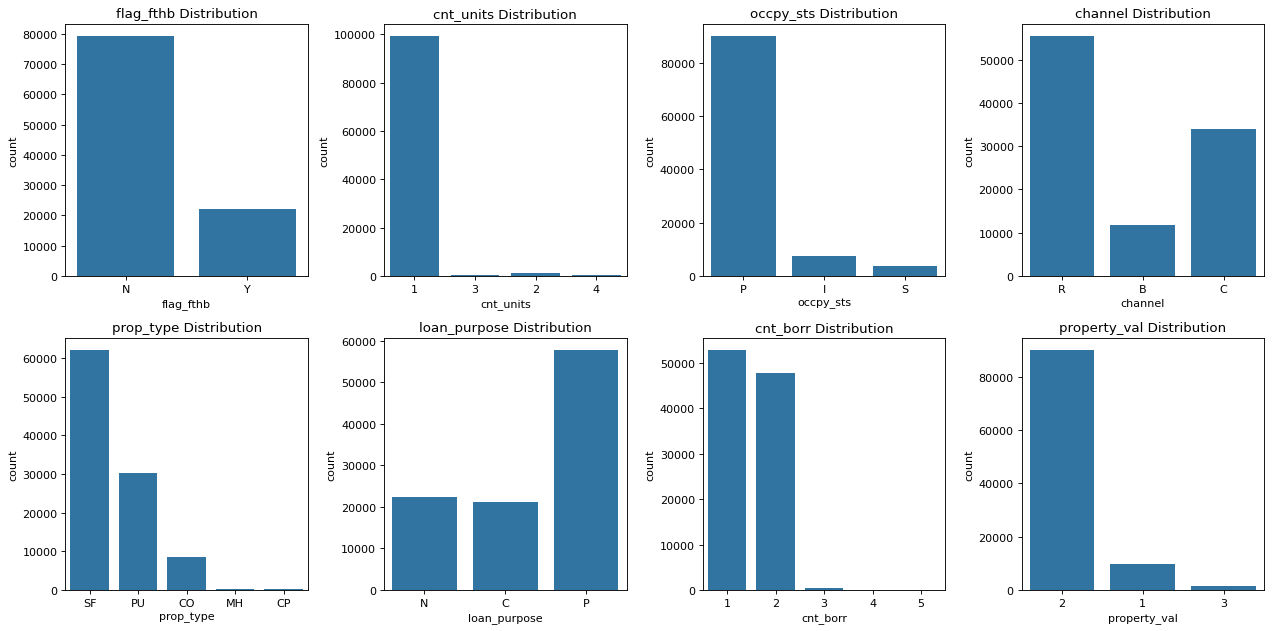

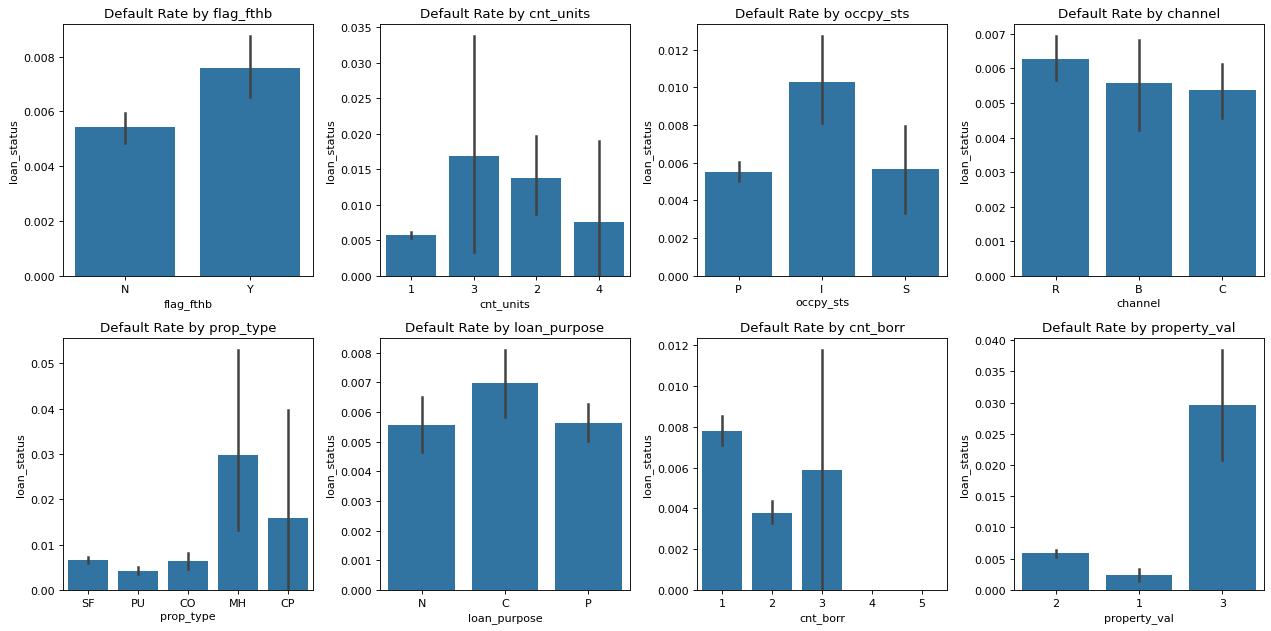

In [49]:
cat_cols = ['flag_fthb', 'cnt_units', 'occpy_sts', 'channel', 'prop_type', 'loan_purpose', 'cnt_borr', 'property_val'] # Categorical columns
n = 2 # Number of rows for subplots
m = len(cat_cols) // n + len(cat_cols) % n # Number of columns for subplots
# Frequency plots
fig, axes = plt.subplots(n, m, figsize=(16, 8))
for i, col in enumerate(cat_cols):
    sns.countplot(x=col, data=train_df, ax=axes[i//m, i%m])
    axes[i//m, i%m].set_title(f'{col} Distribution')
    axes[i//m, i%m].tick_params(axis='x')
plt.tight_layout()
plt.show()

# Relationship with Target
fig, axes = plt.subplots(n, m, figsize=(16, 8))
for i, col in enumerate(cat_cols):
    sns.barplot(x=col, y='loan_status', data=train_df, ax=axes[i//m, i%m], estimator=np.mean)
    axes[i//m, i%m].set_title(f'Default Rate by {col}')
    axes[i//m, i%m].tick_params(axis='x')
plt.tight_layout()
plt.show()


The plots above show the distribution and default rates for key categorical features. While many variables are heavily skewed — for instance, most loans are for single-family homes and primary residences with a single borrower — we can still spot useful patterns. Certain categories stand out with higher default rates, such as investment properties (occpy_sts = I) and manufactured homes (prop_type = MH). These patterns suggest that even though the distributions are imbalanced, some categorical features may carry strong signals for predicting default.

### Correlation Analysis

To check for multicollinearity and understand linear relationships between numerical variables, we compute and visualize a correlation matrix.

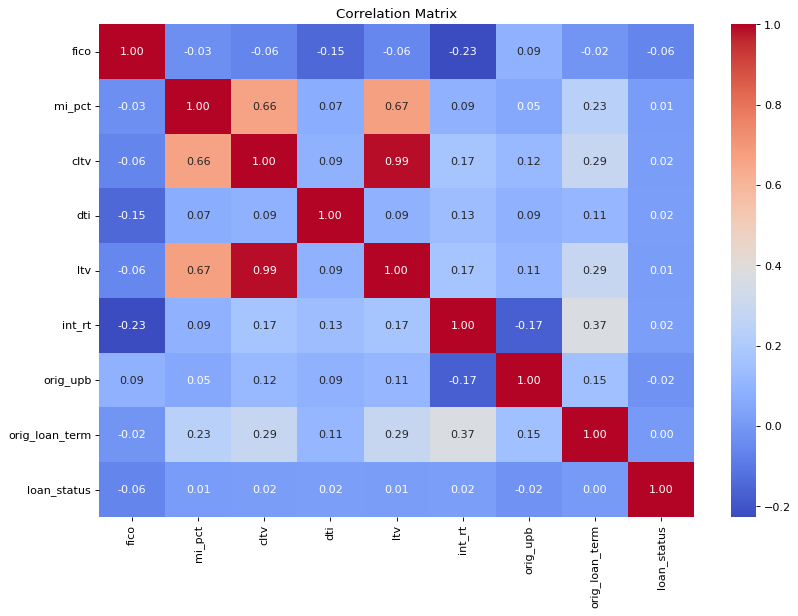

In [50]:
corr_matrix = train_df[num_cols + ['loan_status']].corr()
plt.figure(figsize=(12,8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

This matrix shows how numerical features relate to each other. One key thing that stands out is the extremely high correlation between ltv and cltv—around 0.99—which suggests they carry nearly identical information. Keeping both could introduce multicollinearity, especially in linear models, and add unnecessary complexity. We chose to drop cltv and keep ltv, as LTV is more interpretable, widely used in industry.

In [51]:
X_train = X_train.drop(columns=['cltv'])
X_test = X_test.drop(columns=['cltv'])

We also observed a moderately strong correlation (0.67) between ltv and mi_pct. While this isn’t high enough to trigger concern by itself, we checked their VIF values to make sure they don’t cause multicollinearity issues, which we report in the next step.

In [ ]:
# Compute VIF for features
vif_data = pd.DataFrame()
vif_data["feature"] = X_train[["mi_pct", "ltv"]].columns
vif_data["VIF"] = [variance_inflation_factor(X_train[["mi_pct", "ltv"]].values, i) for i in range(2)]
print(vif_data)

  feature      VIF
0  mi_pct  1.73093
1     ltv  1.73093


The VIF (Variance Inflation Factor) values for numerical features are all below 5, indicating that multicollinearity is not a concern. In particular, both ltv and mi_pct have acceptable VIFs (1.73), so we decide to keep both features in the final model.

### EDA Findings

Our EDA revealed several important patterns that shaped our feature engineering strategy. Defaulted loans, though representing less than 1% of the data, tend to cluster around lower FICO scores, and higher values for DTI, LTV, and interest rate—indicating these financial ratios are closely tied to risk.

In the categorical features, we found that certain infrequent categories—such as investment-purpose loans and manufactured homes—are associated with significantly higher default rates. This suggests that even low-frequency categories can carry strong predictive signals and should be handled carefully.

We also discovered a near-perfect correlation between ltv and cltv (r ≈ 0.99), which raised concerns about multicollinearity. To avoid redundancy and keep the model interpretable, we decided to drop cltv and retain ltv, as it is more commonly used in industry practice.

These insights directly influenced our upcoming steps—especially in how we transform skewed features, construct interaction terms, and streamline the variable set for modeling.

## Feature Engineering

This section focuses on transforming and enriching the feature set to better capture relationships that influence default risk. Based on our EDA findings, we apply skewness correction and construct interaction features that reflect domain knowledge and underlying borrower behavior.

### Transformations and Skewness Checking

To improve model performance and meet assumptions of certain algorithms, we examine the distribution of numerical features and apply transformations where needed. Left-skewed variables (e.g., fico, dti) are normalized using power transforms, while right-skewed ones (e.g., orig_upb) are log-transformed. QQ plots and skewness values are used to evaluate the effectiveness of these transformations.

fico skew: -0.65
fico_pow skew: -0.12
orig_upb skew: 0.78
orig_upb_log skew: -0.52
dti skew: -0.48
dti_pow skew: -0.16


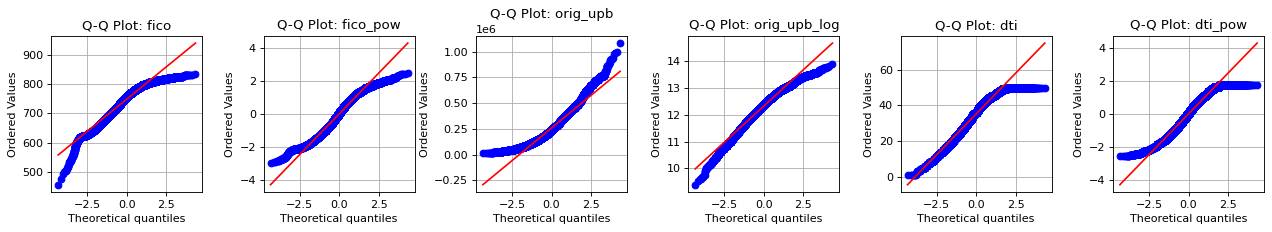

In [ ]:
# Apply log transformation on orig_upb to reduce right skewness
X_train['orig_upb_log'] = np.log1p(X_train['orig_upb'])
X_test['orig_upb_log'] = np.log1p(X_test['orig_upb'])

# Apply Yeo-Johnson transformation on fico to reduce left skewness
pt = PowerTransformer(method='yeo-johnson')
X_train['fico_pow'] = pt.fit_transform(X_train[['fico']])
X_test['fico_pow'] = pt.transform(X_test[['fico']])

# Apply Yeo-Johnson transformation on dti to reduce left skewness
X_train['dti_pow'] = pt.fit_transform(X_train[['dti']])
X_test['dti_pow'] = pt.transform(X_test[['dti']])

# Check skewness of transformed columns
skewed_cols = ['fico', 'fico_pow', 'orig_upb', 'orig_upb_log', 'dti', 'dti_pow']
for col in skewed_cols:
    print(f"{col} skew: {skew(X_train[col]):.2f}")

# Plot Q-Q plots for skewed columns
n = 1
m = len(skewed_cols)//n + len(skewed_cols)%n
fig, axes = plt.subplots(n, m, figsize=(16, n*(16//m+1)))
axes = axes.ravel()  # Flatten axes for easy iteration
for i, col in enumerate(skewed_cols):
    probplot(X_train[col], plot=axes[i]) # Q-Q plot
    axes[i].set_title(f'Q-Q Plot: {col}')
    axes[i].grid(True)
plt.tight_layout()
plt.show()

To address the skewness observed during EDA, we applied transformations to selected numerical features to make their distributions more symmetric and closer to normality, which often helps models learn more effectively. Specifically, we used the Yeo-Johnson transformation for fico and dti, which were left-skewed, and a log transformation for orig_upb, which was heavily right-skewed.

The Yeo-Johnson transform is a flexible power transformation that can handle both positive and negative values. It helps stabilize variance and normalize distributions, making it suitable for variables like fico and dti that include a wide but bounded range. The log transformation is a common choice for right-skewed variables like orig_upb, as it compresses large values and brings the distribution closer to symmetric.

The Q-Q plots above compare the distributions before and after transformation. When the blue dots follow the red diagonal, it indicates the variable is approximately normally distributed. After transformation, skewness values improved significantly—for example, fico changed from –0.65 to –0.12, and orig_upb from 0.78 to –0.52. The transformation of dti had a more modest effect visually, but we observed a slight boost in baseline model performance, which supported keeping the transformed version for consistency across features.

### Interaction Features

To enhance the model’s ability to capture nonlinear patterns and interactions that may influence default risk, we engineered three interaction features based on both domain knowledge and exploratory analysis. 

In [56]:
# Create categorical interaction: occupancy status + property type
# Captures combined effects (e.g., investment properties in condos)
X_train['occpy_prop'] =  X_train['occpy_sts'] + '_' + X_train['prop_type']
X_test['occpy_prop'] =  X_test['occpy_sts'] + '_' + X_test['prop_type']

# Create categorical interaction: loan purpose + number of borrowers
# Identifies purpose-specific borrower patterns (e.g., refinance with multiple borrowers)
X_train['purpose_borr'] = X_train['loan_purpose'] + '_' + X_train['cnt_borr']
X_test['purpose_borr'] = X_test['loan_purpose'] + '_' + X_test['cnt_borr']

# Create numerical interaction: LTV * DTI
# Captures synergistic risk from high leverage and high debt burden
X_train['ltv_dti'] = X_train['ltv'] * X_train['dti']
X_test['ltv_dti'] = X_test['ltv'] * X_test['dti']

First, we combined occupancy status and property type into a single categorical feature (occpy_prop), as certain combinations—like investment properties in condos—might carry distinct risk profiles compared to primary residences in single-family homes. 

Second, we merged loan purpose and number of borrowers into purpose_borr, since scenarios like refinancing with multiple borrowers may indicate different risk behaviors. 

Lastly, we created a numerical interaction feature ltv_dti by multiplying loan-to-value (LTV) and debt-to-income (DTI) ratios to capture the compounded financial risk from both high leverage and high monthly obligations. 

These three features consistently improved model performance and were therefore retained in the final dataset. With our final feature set complete—including original variables, transformed inputs, and engineered interactions—we now move on to the model fitting stage, where we evaluate various classification algorithms to identify the most effective approach for predicting loan default.

# Model Fitting and Tuning

In this section, we fit and evaluate two models for predicting loan default: a baseline logistic regression model and an XGBoost classifier. We also experimented with other models, including Random Forest and a simple neural network, but they did not perform as well in terms of recall and overall stability, so they were not selected. Both final models were trained using the processed feature set and evaluated on the same test data. Given the severe class imbalance, we applied class weighting and threshold adjustment where appropriate. Model performance was assessed using precision, recall, F1 score, and ROC-AUC.

## Baseline model

We implemented a logistic regression model to serve as a transparent and interpretable baseline. While it is a relatively simple model, it allows us to establish a reference point for performance and better understand the contribution of each feature. To handle class imbalance, we used class weighting, and all preprocessing steps—including scaling and encoding—were implemented within a pipeline to ensure consistency.

需要介绍logistic regression model是什么

## 模型建立和表现

              precision    recall  f1-score   support

           0       1.00      0.67      0.80     25192
           1       0.01      0.65      0.02       149

    accuracy                           0.67     25341
   macro avg       0.50      0.66      0.41     25341
weighted avg       0.99      0.67      0.80     25341

Baseline Model Performance:
- Accuracy: 0.6695
- Precision: 0.0115
- Recall: 0.6510
- F1 Score: 0.0226
- ROC-AUC: 0.7176


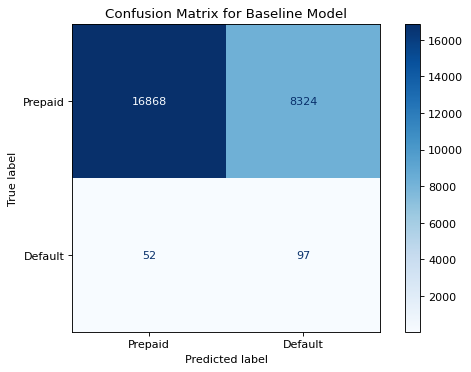

In [ ]:
# Define categorical and numerical features
cat_cols = ['flag_fthb', 'occpy_sts', 'channel', 'loan_purpose', 'cnt_borr', 'occpy_prop', 'prop_type']
num_cols = ['fico_pow', 'mi_pct', 'ltv', 'dti_pow', 'int_rt', 'orig_upb_log', 'orig_loan_term', 'ltv_dti']

# Create a preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
    ]
)

# Combine preprocessing and model into a pipeline
baseline_model = ImPipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(
        class_weight='balanced',  # Adjusts weights for imbalance
        max_iter=1000, 
        random_state=42
    ))
])

# Train the model
baseline_model.fit(X_train, y_train)

# Predict on test data
y_pred = baseline_model.predict(X_test)
y_proba = baseline_model.predict_proba(X_test)[:, 1]  # Probabilities for default

print(classification_report(y_test, y_pred))
# Evaluate performance
print("Baseline Model Performance:")
print(f"- Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"- Precision: {precision_score(y_test, y_pred):.4f}")
print(f"- Recall: {recall_score(y_test, y_pred):.4f}")
print(f"- F1 Score: {f1_score(y_test, y_pred):.4f}")
print(f"- ROC-AUC: {roc_auc_score(y_test, y_proba):.4f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Prepaid', 'Default'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix for Baseline Model')
plt.show()

这五项指标分别是什么，怎么算的，有什么意义

This baseline logistic regression model achieves a recall of 65.1% on the minority class (defaults), meaning it correctly captures most defaults. However, the precision is extremely low (1.15%), indicating that for every predicted default, the vast majority are actually prepaid loans—this is expected in highly imbalanced datasets. The accuracy of 66.95% is largely driven by the dominant majority class (prepaid), and doesn’t reflect the model’s usefulness for the minority class. The ROC-AUC of 0.7176 suggests moderate separability, but the F1 score of just 0.0226 shows poor balance between precision and recall.

To handle the class imbalance, we compared several approaches—including over-sampling, under-sampling, and using class_weight='balanced'—and found that all yielded similar results. Given its simplicity and ease of integration into the logistic regression pipeline, we selected class_weight='balanced' as our final strategy.

The confusion matrix reinforces this pattern. While 97 out of 149 defaults were correctly identified, 52 were missed, and over 8,300 prepaid loans were incorrectly classified as defaults. This means the model is somewhat successful at detecting defaults but does so with a large number of false positives, limiting its practicality without further refinement.

## ROC和PR曲线

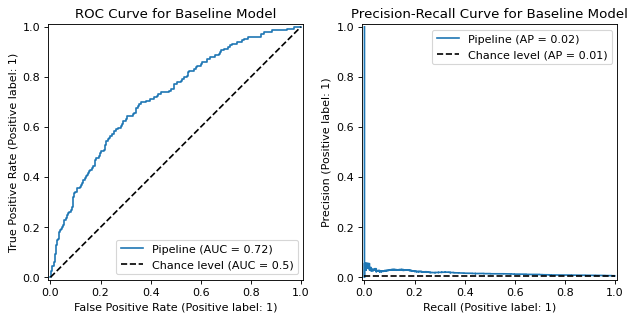

In [71]:
fig, axes = plt.subplots(1, 2)

# ROC Curve
RocCurveDisplay.from_estimator(baseline_model, X_test, y_test, ax=axes[0], plot_chance_level=True)
axes[0].set_title('ROC Curve for Baseline Model')

# Precision-Recall Curve
PrecisionRecallDisplay.from_estimator(baseline_model, X_test, y_test, ax=axes[1], plot_chance_level=True)
axes[1].set_title('Precision-Recall Curve for Baseline Model')
axes[1].legend(loc='upper right')

plt.tight_layout()
plt.show()

These two plots help us understand how well the baseline logistic regression model performs overall. The ROC curve on the left shows that the model has a reasonable ability to distinguish between defaults and prepaid loans, with an AUC of 0.72—definitely better than random guessing.

But the precision-recall curve on the right paints a more realistic picture in this imbalanced setting. While the model achieves decent recall, the precision is extremely low, with an average precision (AP) of just 0.02. That means most of the predictions labeled as “default” are actually false alarms.

需要解释这两张图是什么，怎么看

左图0.5线类似随机抛硬币，我们的模型有一定的预测准确性

右图同理

## 特征系数总览

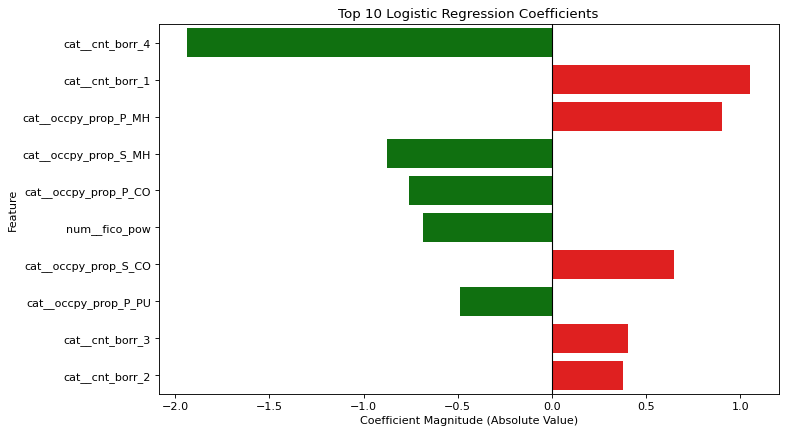

In [72]:
# Get feature names from the preprocessor
feature_names = baseline_model.named_steps['preprocessor'].get_feature_names_out()

# Extract coefficients from logistic regression
coefficients = baseline_model.named_steps['classifier'].coef_[0]

# Create a DataFrame for interpretation
coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients,
    'Abs_Coefficient': np.abs(coefficients)
}).sort_values(by='Abs_Coefficient', ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(
    x='Coefficient', 
    y='Feature', 
    hue='Feature',
    data=coef_df.head(10),
    palette=['Red' if x > 0 else 'Green' for x in coef_df.head(10)['Coefficient']]
    )
plt.axvline(0, color='black', linestyle='-', linewidth=1)
plt.title('Top 10 Logistic Regression Coefficients')
plt.xlabel('Coefficient Magnitude (Absolute Value)')
plt.show()

This plot shows the top 10 most influential features from our logistic regression model, based on the size of their coefficients. Features with positive coefficients (on the right) increase the model’s likelihood of predicting a default. For example, having only one borrower (cnt_borr_1) or a manufactured home as a primary residence (occpy_prop_P_MH) are linked with higher default risk.

On the left, we see features with negative coefficients—those that reduce the predicted risk of default. Notably, having four borrowers (cnt_borr_4) shows the strongest protective effect, and a higher FICO score (fico_pow) is also associated with better repayment, which aligns with our earlier findings.

This gives us confidence that the model is learning meaningful patterns, and it also confirms that some of our engineered features—like borrower count and the combined occupancy/property type—are adding real predictive value.

模型：对于线性回归基线，当特征未缩放时，对最强预测因子的评论需谨慎。

系数高表示该特征在这个模型中的贡献大，不一定具有实际意义

## XGBoost

To improve upon the baseline and better handle the complexity of the data, We used XGBoost as our final model due to its strong performance on tabular data and its built-in support for handling imbalanced classification tasks.

需要介绍XGBoost是什么

## 模型建立

In [73]:
# Define full categorical and numerical features
cat_cols = ['flag_fthb', 'occpy_sts', 'channel', 'prop_type', 'loan_purpose', 'mi_cancel_ind', 'cnt_borr', 
            'cnt_units', 'property_val', 'cd_msa', 'zipcode', 'st', 'occpy_prop', 'purpose_borr'
]

num_cols = ['fico', 'fico_pow', 'mi_pct', 'dti', 'dti_pow', 'ltv', 'int_rt', 
    'orig_upb', 'orig_upb_log', 'orig_loan_term', 'ltv_dti'
]

# Preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
    ],
    remainder='passthrough',  # Pass numerical features unchanged
)

# Calculate scale_pos_weight for XGBoost
neg = len(y_train[y_train == 0])
pos = len(y_train[y_train == 1])
scale_pos_weight = neg / pos
print(f"scale_pos_weight: {scale_pos_weight:.2f}")

scale_pos_weight: 168.79


For the XGBoost model, we included all available features—both original and engineered—without dropping high-cardinality or interaction terms. Tree-based models like XGBoost are generally robust to feature redundancy and can naturally capture non-linear interactions, making them well-suited to learning patterns even from raw, less-processed inputs. While we considered using target encoding for high-cardinality categorical features (e.g., zipcode, cd_msa), one-hot encoding consistently performed better in our validation results, likely due to reduced target leakage and more stable splits.

To handle class imbalance, we calculated scale_pos_weight as the ratio of negative to positive samples in the training set, resulting in a value of 168.79. This parameter plays a critical role in helping XGBoost correctly account for the rare default cases during training by assigning greater importance to the minority class without changing the underlying data distribution.

## 寻找最优参数

In [ ]:
# Define parameter grid
param_grid = {
    'classifier__subsample': [0.95, 1.0], # [0.5, 1.0]
    'classifier__n_estimators': [175, 200, 225, 250], # [50, 2000]
    'classifier__max_depth': [2, 3, 4],  # [1, 20]
    'classifier__learning_rate': [0.075, 0.1, 0.125, 0.15], # [0.01, 0.3]
    'classifier__colsample_bytree': [0.9, 0.95, 1.0] # [0.5, 1.0]
    }

# Create pipeline
xgb_model = ImPipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(sampling_strategy=0.3, random_state=42)),  # Optional: add SMOTE for oversampling
    ('classifier', XGBClassifier(
        objective='binary:logistic',
        scale_pos_weight=scale_pos_weight,  # Adjust for class imbalance
        random_state=42,
        eval_metric='auc'
    ))
])

# RandomizedSearchCV with stratified K-fold
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
search = RandomizedSearchCV(
    xgb_model,
    param_grid,
    n_iter=20,
    scoring='roc_auc', # Aim for AUC
    cv=cv,
    n_jobs=-1
)

# Fit model
search.fit(X_train, y_train)
# Get best parameters without the pipeline prefix
best_params = {k.replace('classifier__', ''): v for k, v in search.best_params_.items()}

# 假装随机到这个参数，最后运行完要删掉
best_params = {
    'subsample': 0.95,
    'n_estimators': 200,
    'max_depth': 2,
    'learning_rate': 0.15,
    'colsample_bytree': 1.0
}

# Best parameters
print("Best Parameters:", best_params)

Best Parameters: {'subsample': 0.95, 'n_estimators': 200, 'max_depth': 2, 'learning_rate': 0.15, 'colsample_bytree': 1.0}


We used RandomizedSearchCV to tune the XGBoost hyperparameters, aiming to maximize ROC-AUC through stratified 3-fold cross-validation. Compared to grid search, this approach is more efficient for exploring a wide range of parameters, especially when some combinations have minimal impact on performance.

Although scale_pos_weight was already addressing class imbalance, we also included SMOTE as an additional preprocessing step during tuning. SMOTE helps generate synthetic minority class samples, which can further improve recall in imbalanced datasets and make the cross-validation process more stable.

介绍SMOTE是什么，什么时候用，他的工作原理是什么

In practice, we found that a specific parameter configuration performed consistently better than others. Since randomized search does not guarantee it will test that exact combination, we manually set it as our final model after tuning. We chose not to tune gamma because in our preliminary testing, it had little to no effect on model performance and was not considered critical for this task.

## 模型fit

In [76]:
# Initialize final model with tuned parameters
final_model = ImPipeline([
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(
        **best_params,
        objective='binary:logistic',
        scale_pos_weight=scale_pos_weight,
        random_state=42
    ))
])

# Train
final_model.fit(X_train, y_train)
print("Final Model Trained")

Final Model Trained


Even though we used SMOTE during the parameter tuning stage to help the model better learn from the minority class, we didn’t include it when training the final model. That’s actually pretty common—sometimes（不表示一般情况） oversampling helps during tuning, but using synthetic data in the final model can hurt generalization. In our case, just using the original imbalanced data and setting scale_pos_weight properly gave us better results. Since XGBoost already has good built-in support for imbalanced datasets, we were able to get strong performance without needing SMOTE at this stage.

## 模型预测

              precision    recall  f1-score   support

           0       1.00      0.71      0.83     25192
           1       0.01      0.70      0.03       149

    accuracy                           0.71     25341
   macro avg       0.51      0.71      0.43     25341
weighted avg       0.99      0.71      0.83     25341

XGBoost Performance:
- Accuracy: 0.7131
- Precision: 0.0142
- Recall: 0.6980
- F1 Score: 0.0278
- ROC-AUC: 0.7656


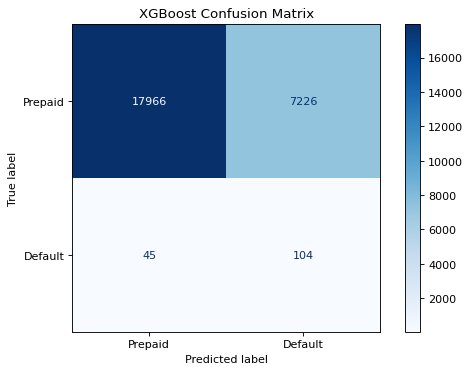

In [77]:
# Predictions
y_pred_xgb = final_model.predict(X_test)
y_proba_xgb = final_model.predict_proba(X_test)[:, 1]

threshold = 0.45  # Adjust based on PR curve analysis
y_pred_xgb = (y_proba_xgb >= threshold).astype(int)
print(classification_report(y_test, y_pred_xgb))
# Performance metrics
print("XGBoost Performance:")
print(f"- Accuracy: {accuracy_score(y_test, y_pred_xgb):.4f}")
print(f"- Precision: {precision_score(y_test, y_pred_xgb):.4f}")
print(f"- Recall: {recall_score(y_test, y_pred_xgb):.4f}")
print(f"- F1 Score: {f1_score(y_test, y_pred_xgb):.4f}")
print(f"- ROC-AUC: {roc_auc_score(y_test, y_proba_xgb):.4f}")

# Confusion Matrix
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
disp_xgb = ConfusionMatrixDisplay(confusion_matrix=cm_xgb, display_labels=['Prepaid', 'Default'])
disp_xgb.plot(cmap='Blues')
plt.title('XGBoost Confusion Matrix')
plt.show()

This output summarizes the performance of our final XGBoost model on the test set, using a classification threshold of 0.45. Instead of the default 0.5, we selected this lower threshold based on the precision-recall curve, aiming to increase recall for the minority class (defaults), which is the primary focus of our task.

The model achieved a recall of 69.8% on defaults, successfully identifying most default cases—an improvement over the baseline. Precision remains low at 1.42%, which is expected given the class imbalance, but the trade-off results in fewer missed defaults. The F1 score also shows a slight gain, reflecting a better balance between precision and recall.

The confusion matrix further illustrates this: 104 out of 149 defaults were correctly identified, while 45 were missed. Around 7,200 prepaid loans were incorrectly flagged as defaults. Although this results in a relatively high number of false positives, it is acceptable in a setting where catching defaults is more important than avoiding false alarms.

Overall, the model’s accuracy improved to 71.3%, and the ROC-AUC increased to 0.7656, indicating stronger overall separation between classes. The use of a tuned threshold contributed meaningfully to these improvements.

## ROC和PR曲线

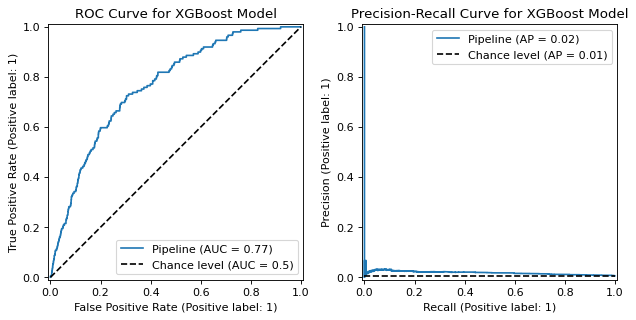

In [64]:
fig, axes = plt.subplots(1, 2)

# ROC Curve
RocCurveDisplay.from_estimator(final_model, X_test, y_test, ax=axes[0], plot_chance_level=True)
axes[0].set_title('ROC Curve for XGBoost Model')

# Precision-Recall Curve
PrecisionRecallDisplay.from_estimator(final_model, X_test, y_test, ax=axes[1], plot_chance_level=True)
axes[1].set_title('Precision-Recall Curve for XGBoost Model')
axes[1].legend(loc='upper right')

plt.tight_layout()
plt.show()

The ROC and Precision-Recall curves above summarize the XGBoost model’s performance. With an ROC-AUC of 0.77, the model shows strong overall separability. The PR curve indicates that while precision is still low, the model performs consistently better than chance.

Compared to the baseline, XGBoost improves slightly in ROC-AUC while maintaining similar precision-recall trade-offs.

## SHAP

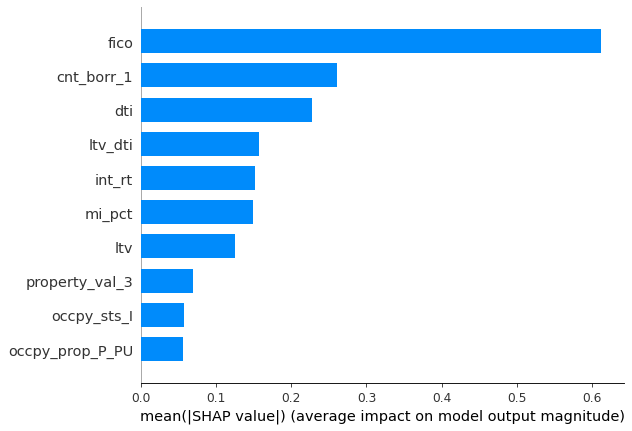

In [65]:
# Extract feature names after one-hot encoding
encoder = final_model.named_steps['preprocessor'].named_transformers_['cat']
cat_features = encoder.get_feature_names_out(cat_cols)
all_features = np.concatenate([cat_features, num_cols])

# Get preprocessed data
X_processed = final_model.named_steps['preprocessor'].transform(X_train)

# SHAP summary plot
explainer = shap.TreeExplainer(final_model.named_steps['classifier'])
shap_values = explainer.shap_values(X_processed)
shap.summary_plot(shap_values, X_processed, feature_names=all_features, plot_type='bar', max_display=10)

介绍SHAP是什么，什么原理，为什么具有可靠性和现实意义

This SHAP summary plot gives us a clear picture of which features had the most impact on our XGBoost model’s predictions. SHAP values help explain how much each feature contributes to pushing a prediction toward default or not, on average. We can see that FICO score is by far the most important feature—its impact is much larger than any other variable. Other key contributors include cnt_borr_1, DTI, and ltv_dti. These results make sense and align well with what we’d expect.

## 对比

In [68]:
print("Baseline vs XGBoost Comparison:")
print(f"Metric\t\tBaseline\tXGBoost")
print(f"Accuracy\t{accuracy_score(y_test, y_pred):.4f}\t\t{accuracy_score(y_test, y_pred_xgb):.4f}")
print(f"Precision\t{precision_score(y_test, y_pred):.4f}\t\t{precision_score(y_test, y_pred_xgb):.4f}")
print(f"Recall\t\t{recall_score(y_test, y_pred):.4f}\t\t{recall_score(y_test, y_pred_xgb):.4f}")
print(f"F1 Score\t{f1_score(y_test, y_pred):.4f}\t\t{f1_score(y_test, y_pred_xgb):.4f}")
print(f"ROC-AUC\t\t{roc_auc_score(y_test, y_proba):.4f}\t\t{roc_auc_score(y_test, y_proba_xgb):.4f}")

Baseline vs XGBoost Comparison:
Metric		Baseline	XGBoost
Accuracy	0.6697		0.7131
Precision	0.0115		0.0142
Recall		0.6510		0.6980
F1 Score	0.0227		0.0278
ROC-AUC		0.7166		0.7656


This final comparison highlights XGBoost’s consistent improvement over the baseline logistic regression model across all metrics. While the absolute gains are not dramatic, they are meaningful—XGBoost achieved higher accuracy (71.3% vs. 66.97%), recall (69.8% vs. 65.1%), and F1 score (0.0278 vs. 0.0227). Its ROC-AUC also increased from 0.7166 to 0.7656, indicating stronger overall ability to separate defaults from non-defaults.

Although precision remains low—expected in such an imbalanced classification task—the model strikes a better balance between identifying defaults and avoiding too many false positives. These consistent gains across the board support the choice of XGBoost as our final model.

# Discussion & Conclusions

The final XGBoost model shows strong and consistent performance in identifying mortgage loans at risk of default. Trained on Freddie Mac loan-level data, it achieved a recall of 69.8%, meaning it correctly flagged the majority of default cases in the test set. It also reached 71.3% accuracy and an ROC-AUC of 0.7656, indicating good overall separation between defaulted and non-defaulted loans. Compared to the baseline logistic regression model, which had a recall of 65.1% and AUC of 0.7176, XGBoost delivers clear improvement across all key metrics, reinforcing its reliability.

In terms of features, fico was by far the most important predictor, followed by cnt_borr, dti, and the engineered interaction term ltv_dti. These results align well with financial expectations—lower credit scores, higher debt burdens, and single-borrower loans are consistently associated with higher default risk. SHAP analysis confirmed that the model is making decisions based on logical and interpretable relationships in the data.

While precision remains low—due to the highly imbalanced nature of defaults—the model effectively minimizes missed defaults, which is more critical in early-stage risk detection. The improved recall and AUC suggest the model is well-suited for identifying risky loans, even if further steps are needed to refine false positives.

In conclusion, our XGBoost model improves upon the baseline in both predictive performance and feature insight. It provides a stable, interpretable, and actionabfoundation for supporting mortgage default risk management.

应该添加更具体的陈述，将所选模型的系数与解释、预测分数和建议联系起来

要向客户介绍我们模型预测结果的意义，如何使用，可靠性，和措施

比如模型的precision为0.01表示预测100个defualt仅有1个会真正违约，需要客户做好相应风险控制，比如综合考虑误报和遗漏成本

# Generative AI statement

In this project, we used generative AI solely as a tool to assist with debugging code. All data and analysis results were processed and evaluated by us. The AI helped us refine our code and address errors, ensuring the technical aspects of the project were accurate and functional. The final outcomes and interpretations are entirely our own, and we have adhered to responsible use of AI as outlined in the guidelines.

# References

[1] mlp_week06_key.ipynb

[2] mlp_week11_key.ipynb

In [3]:
# Run the following to render to PDF
!jupyter nbconvert --to pdf project2.ipynb

[NbConvertApp] Converting notebook project2.ipynb to pdf
[NbConvertApp] Support files will be in project2_files\
[NbConvertApp] Making directory .\project2_files
[NbConvertApp] Writing 119390 bytes to notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', 'notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: ['bibtex', 'notebook']
[NbConvertApp] WARNING | b had problems, most likely because there were no citations
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 546466 bytes to project2.pdf
